<a href="https://colab.research.google.com/github/hunterkilltree/Deep-Learning/blob/master/%5BFoDL03%5D_Assignment01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This assignment is a modified version of [Stanford's CS231n](http://cs231n.stanford.edu/) course materials.

[Stanford's CS231n lecture notes](https://cs231n.github.io/) will be a very useful reference for this assignment.

In [27]:
!git clone https://github.com/vietai-courses/Fo-Deep-Learning-03.git
%cd Fo-Deep-Learning-03/Assignment_01

Cloning into 'Fo-Deep-Learning-03'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 7 (delta 0), reused 7 (delta 0), pack-reused 0
Receiving objects: 100% (7/7), 7.20 KiB | 7.20 MiB/s, done.
/content/Fo-Deep-Learning-03/Assignment_01/Fo-Deep-Learning-03/Assignment_01


In [31]:
# This downloads the CIFAR-10 dataset if it doesn't already exist.

!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz
!pip install matplotlib

--2024-05-28 00:53:30--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  13.2MB/s    in 14s     

2024-05-28 00:53:45 (11.5 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [32]:
from utils.utils import *
from utils.calculate import *
from utils.solver import Solver

In [33]:
# Load the (preprocessed) CIFAR10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


In [34]:
# Setup cell.
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Q1: Multi-Layer Fully Connected Network (25 points)
In this exercise, you will implement a fully connected network with an arbitrary number of hidden layers.


## Stochastic Gradient Descent (SGD) Update Rule (5 points)
The update rule is pivotal in neural networks and other machine learning models, as it guides the model in updating its parameters, such as weights, to better fit the data.

In [35]:
"""
The update rule accepts current weights and the
gradient of the loss with respect to those weights and produces the next set of
weights. Each update rule has the same interface:

def update(w, dw, config=None):

Inputs:
  - w: A numpy array giving the current weights.
  - dw: A numpy array of the same shape as w giving the gradient of the
    loss with respect to w.
  - config: A dictionary containing hyperparameter values such as learning
    rate, momentum, etc. If the update rule requires caching values over many
    iterations, then config will also hold these cached values.

Returns:
  - next_w: The next point after the update.
  - config: The config dictionary to be passed to the next iteration of the
    update rule.

For efficiency, the update rule may perform in-place updates, mutating w and
setting next_w equal to w.
"""

def sgd(w, dw, config=None):
    """
    Performs vanilla stochastic gradient descent.
    config format:
    - learning_rate: Scalar learning rate.
    """
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-2)
    ###########################################################################
    # TODO: Implement the vanilla stochastic gradient descent update formula. #
    ###########################################################################

     # Perform the vanilla stochastic gradient descent update
    w -= config["learning_rate"] * dw

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return w, config


Read through the `FullyConnectedNet` class and utils function provided. Implement the forward pass and backward pass.

You can re-use your implementations for `linear_forward`, `linear_backward`, `relu_forward`, `relu_backward`, `linear_relu_forward`, `linear_relu_backward` and `softmax_loss` from the previous tutorials. For right now, don't worry about implementing dropout or batch/layer normalization yet, as you will add those features later.

For a network with L layers, the architecture you have to implement in this assignment will be

    {linear - relu} x (L - 1) - linear - softmax

**HIỆN THỰC CODE Ở PHẦN "YOUR CODE HERE"**

## FullyConnectedNet for Forward and Backward (20 points)

In [36]:
class FullyConnectedNet(object):
    """Class for a multi-layer fully connected neural network.

    Network contains an arbitrary number of hidden layers, ReLU nonlinearities,
    and a softmax loss function. This will also implement dropout and batch/layer
    normalization as options. For a network with L layers, the architecture will be

    {linear - [batch/layer norm] - relu - [dropout]} x (L - 1) - linear - softmax

    where batch/layer normalization and dropout are optional and the {...} block is
    repeated L - 1 times.

    Learnable parameters are stored in the self.params dictionary and will be learned
    using the Solver class.
    """

    def __init__(
        self,
        hidden_dims,
        input_dim=3 * 32 * 32,
        num_classes=10,
        dropout_keep_ratio=1,
        normalization=None,
        reg=0.0,
        weight_scale=1e-2,
        dtype=np.float32,
        seed=None,
    ):
        """Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - dropout_keep_ratio: Scalar between 0 and 1 giving dropout strength.
            If dropout_keep_ratio=1 then the network should not use dropout at all.
        - normalization: What type of normalization the network should use. Valid values
            are "batchnorm", "layernorm", or None for no normalization (the default).
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
            initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
            this datatype. float32 is faster but less accurate, so you should use
            float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers.
            This will make the dropout layers deteriminstic so we can gradient check the model.
        """
        self.normalization = normalization
        self.use_dropout = dropout_keep_ratio != 1
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        szs = [input_dim] + hidden_dims + [num_classes]
        for i in range(self.num_layers):
            self.params[f"W{i+1}"] = np.random.normal(0., weight_scale, size=(szs[i], szs[i+1]))
            self.params[f"b{i+1}"] = np.zeros(szs[i+1])

        # Cast all parameters to the correct datatype.
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)

    def loss(self, X, y=None):
        """Compute loss and gradient for the fully connected net.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
            scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
            names to gradients of the loss with respect to those parameters.
        """
        X = X.astype(self.dtype)
        mode = "test" if y is None else "train"

        # Set train/test mode for batchnorm params and dropout param since they
        # behave differently during training and testing.
        if self.use_dropout:
            self.dropout_param["mode"] = mode
        if self.normalization == "batchnorm":
            for bn_param in self.bn_params:
                bn_param["mode"] = mode
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the fully connected net, computing  #
        # the class scores for X and storing them in the scores variable.          #
        #                                                                          #
        # When using dropout, you'll need to pass self.dropout_param to each       #
        # dropout forward pass.                                                    #
        #                                                                          #
        # When using batch normalization, you'll need to pass self.bn_params[0] to #
        # the forward pass for the first batch normalization layer, pass           #
        # self.bn_params[1] to the forward pass for the second batch normalization #
        # layer, etc.                                                              #
        ############################################################################
        # YOUR CODE HERE
        caches = []
        dropout_caches = []

        out = X
        for i in range(self.num_layers - 1):
            W = self.params[f'W{i+1}']
            b = self.params[f'b{i+1}']
            if self.normalization:
                gamma = self.params[f'gamma{i+1}']
                beta = self.params[f'beta{i+1}']
                out, cache = linear_norm_relu_forward(self.normalization, out, W, b, gamma, beta, self.bn_params[i])
            else:
                out, cache = linear_relu_forward(out, W, b)
            if self.use_dropout:
                out, do_cache = dropout_forward(out, self.dropout_param)
                cache = (cache, do_cache)
                dropout_caches.append(do_cache)
            caches.append(cache)

        W = self.params[f'W{self.num_layers}']
        b = self.params[f'b{self.num_layers}']
        scores, final_cache = linear_forward(out, W, b)
        caches.append(final_cache)


        # If test mode return early.
        if mode == "test":
            return scores

        loss, grads = 0.0, {}
        ############################################################################
        # TODO: Implement the backward pass for the fully-connected net. Store the #
        # loss in the loss variable and gradients in the grads dictionary. Compute #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # When using batch/layer normalization, you don't need to regularize the   #
        # scale and shift parameters.                                              #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        # YOUR CODE HERE

        loss, dscores = softmax_loss(scores, y)

        for i in range(self.num_layers):
            W = self.params[f'W{i+1}']
            loss += 0.5 * self.reg * np.sum(W * W)

        dout, dW, db = linear_backward(dscores, caches.pop())
        grads[f'W{self.num_layers}'] = dW + self.reg * W
        grads[f'b{self.num_layers}'] = db

        for i in reversed(range(self.num_layers - 1)):
            if self.use_dropout:
                cache, do_cache = caches.pop()
                dout = dropout_backward(dout, do_cache)
            else:
                cache = caches.pop()
            if self.normalization:
                dx, dW, db, dgamma, dbeta = linear_norm_relu_backward(self.normalization, dout, cache)
                grads[f'gamma{i+1}'] = dgamma
                grads[f'beta{i+1}'] = dbeta
            else:
                dx, dW, db = linear_relu_backward(dout, cache)
            grads[f'W{i+1}'] = dW + self.reg * self.params[f'W{i+1}']
            grads[f'b{i+1}'] = db
            dout = dx

        return loss, grads

### Public Test

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. This is a good way to see if the initial losses seem reasonable.

For gradient checking, you should expect to see errors around 1e-7 or less.

In [37]:
np.random.seed(42)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print("Running check with reg = ", reg)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2,
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    print("Initial loss: ", loss)

    # Most of the errors should be on the order of e-7 or smaller.
    # NOTE: It is fine however to see an error for W2 on the order of e-5
    # for the check when reg = 0.0
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        # print(f"{name} relative error: {rel_error(grad_num, grads[name])}")
        assert rel_error(grad_num, grads[name]) < 1.0e-5

Running check with reg =  0
Initial loss:  2.309647806660724
Running check with reg =  3.14
Initial loss:  6.834753343737317


### TODO: Use a three-layer Net to overfit 50 training examples by
### tweaking just the learning rate and initialization scale.

***Challenge***: As another sanity check, make sure your network can overfit on a small dataset of 50 images. First, we will try a three-layer network with 100 units in each hidden layer.
In the following cell, tweak the **learning rate** to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 208.646659
(Epoch 0 / 20) train acc: 0.380000; val_acc: 0.149000
(Epoch 1 / 20) train acc: 0.220000; val_acc: 0.091000
(Epoch 2 / 20) train acc: 0.560000; val_acc: 0.130000


/content/Fo-Deep-Learning-03/Assignment_01/utils/calculate.py:116: RuntimeWarning: divide by zero encountered in log
  loss = -np.log(probs[range(len(y)), y])


(Epoch 3 / 20) train acc: 0.780000; val_acc: 0.134000
(Epoch 4 / 20) train acc: 0.800000; val_acc: 0.123000
(Epoch 5 / 20) train acc: 0.860000; val_acc: 0.140000
(Iteration 11 / 40) loss: 1.430910
(Epoch 6 / 20) train acc: 0.880000; val_acc: 0.143000
(Epoch 7 / 20) train acc: 0.920000; val_acc: 0.129000
(Epoch 8 / 20) train acc: 0.920000; val_acc: 0.129000
(Epoch 9 / 20) train acc: 0.920000; val_acc: 0.128000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.137000
(Iteration 21 / 40) loss: 0.000007
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.137000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.137000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.137000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.137000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.137000
(Iteration 31 / 40) loss: 0.000000
(Epoch 16 / 20) train acc: 1.000000; val_acc: 0.137000
(Epoch 17 / 20) train acc: 1.000000; val_acc: 0.137000
(Epoch 18 / 20) train acc: 1.000000; val_acc: 0.137000
(Epoch 19 / 20) train 

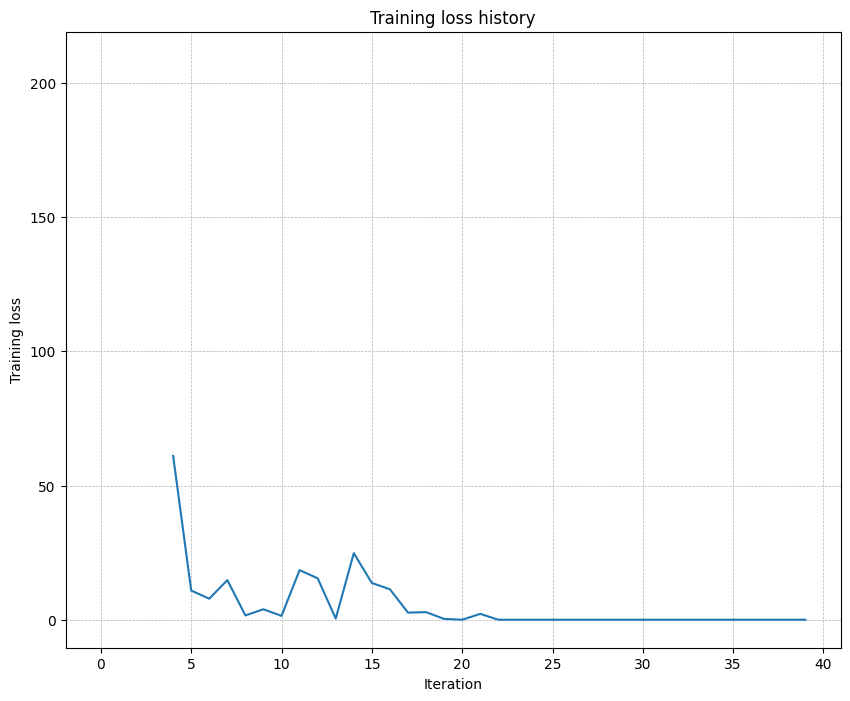

In [38]:
num_train = 50
small_data = {
  "X_train": data["X_train"][:num_train],
  "y_train": data["y_train"][:num_train],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}

weight_scale = 1e-1
learning_rate = 1e-3  # Experiment with this!
model = FullyConnectedNet(
    [100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule=sgd,
    optim_config={"learning_rate": learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

### TODO: Use a five-layer Net to overfit 50 training examples by
### tweaking just the learning rate and initialization scale.

***Challenge***: Now, try to use a five-layer network with 100 units on each layer to overfit on 50 training examples. Again, you will have to adjust the learning rate, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 96.402280
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.096000
(Epoch 1 / 20) train acc: 0.280000; val_acc: 0.122000
(Epoch 2 / 20) train acc: 0.260000; val_acc: 0.096000
(Epoch 3 / 20) train acc: 0.440000; val_acc: 0.136000
(Epoch 4 / 20) train acc: 0.680000; val_acc: 0.120000
(Epoch 5 / 20) train acc: 0.780000; val_acc: 0.116000
(Iteration 11 / 40) loss: 2.841105
(Epoch 6 / 20) train acc: 0.900000; val_acc: 0.129000
(Epoch 7 / 20) train acc: 0.940000; val_acc: 0.132000
(Epoch 8 / 20) train acc: 0.980000; val_acc: 0.139000
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.141000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.135000
(Iteration 21 / 40) loss: 0.006949
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.135000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.135000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.135000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.135000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.134000
(Iteration 31 / 40) loss:

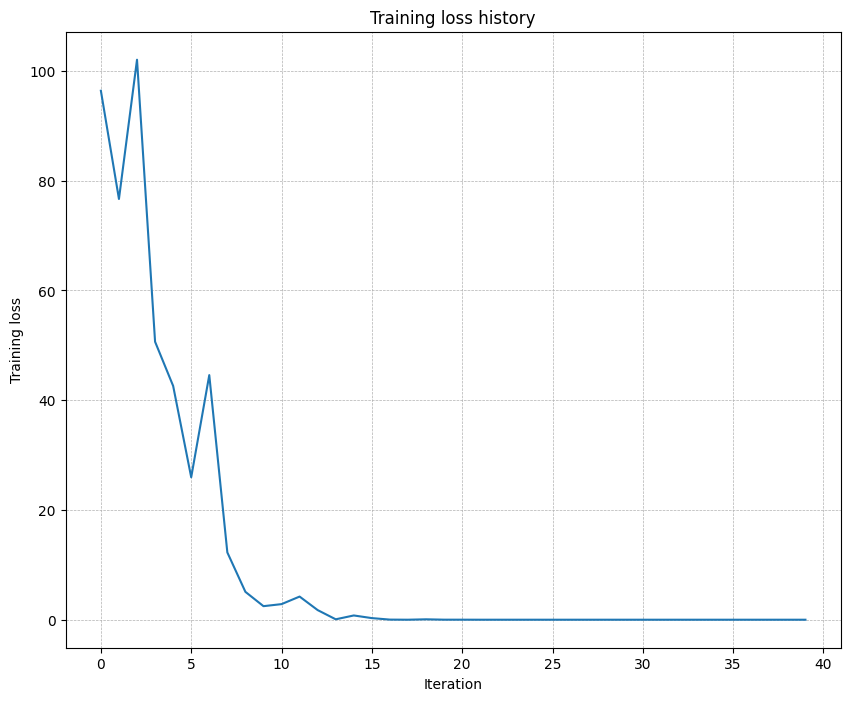

In [39]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-1
learning_rate = 1e-3  # Experiment with this!
model = FullyConnectedNet(
    [100, 100, 100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule=sgd,
    optim_config={'learning_rate': learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

# Q2: SGD+Momentum (10 points)
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Implement the SGD+momentum update rule in the function `sgd_momentum` below.

In [40]:
def sgd_momentum(w, dw, config=None):
    """
    Performs stochastic gradient descent with momentum.

    config format:
    - learning_rate: Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.
      Setting momentum = 0 reduces to sgd.
    - velocity: A numpy array of the same shape as w and dw used to store a
      moving average of the gradients.
    """
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-2)
    config.setdefault("momentum", 0.9)
    v = config.get("velocity", np.zeros_like(w))

    next_w = None
    ###########################################################################
    # TODO: Implement the momentum update formula. Store the updated value in #
    # the next_w variable. You should also use and update the velocity v.     #
    ###########################################################################
    # YOUR CODE HERE
    learning_rate = config["learning_rate"]
    momentum = config["momentum"]

    # Update the velocity
    v = momentum * v - learning_rate * dw

    # Update the weights
    next_w = w + v

    config["velocity"] = v

    return next_w, config

### Public test
Run the following to check your implementation. You should see errors less than e-8.

In [41]:
N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {"learning_rate": 1e-3, "velocity": v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
# print("next_w error: ", rel_error(next_w, expected_next_w))
# print("velocity error: ", rel_error(expected_velocity, config["velocity"]))
assert rel_error(next_w, expected_next_w) < 1.0e-8
assert rel_error(expected_velocity, config["velocity"]) < 1.0e-8

### Private test

Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

Running with <function sgd at 0x7caaf8af5750>
(Iteration 1 / 200) loss: 2.545587
(Epoch 0 / 5) train acc: 0.111000; val_acc: 0.108000
(Iteration 11 / 200) loss: 2.285758
(Iteration 21 / 200) loss: 2.207590
(Iteration 31 / 200) loss: 2.190390
(Epoch 1 / 5) train acc: 0.236000; val_acc: 0.218000
(Iteration 41 / 200) loss: 2.236002
(Iteration 51 / 200) loss: 2.168594
(Iteration 61 / 200) loss: 1.946256
(Iteration 71 / 200) loss: 1.912031
(Epoch 2 / 5) train acc: 0.280000; val_acc: 0.270000
(Iteration 81 / 200) loss: 2.112334
(Iteration 91 / 200) loss: 1.912850
(Iteration 101 / 200) loss: 1.846610
(Iteration 111 / 200) loss: 2.080923
(Epoch 3 / 5) train acc: 0.314000; val_acc: 0.293000
(Iteration 121 / 200) loss: 1.932436
(Iteration 131 / 200) loss: 1.795119
(Iteration 141 / 200) loss: 1.869913
(Iteration 151 / 200) loss: 1.804911
(Epoch 4 / 5) train acc: 0.362000; val_acc: 0.301000
(Iteration 161 / 200) loss: 1.871296
(Iteration 171 / 200) loss: 1.908019
(Iteration 181 / 200) loss: 1.7955

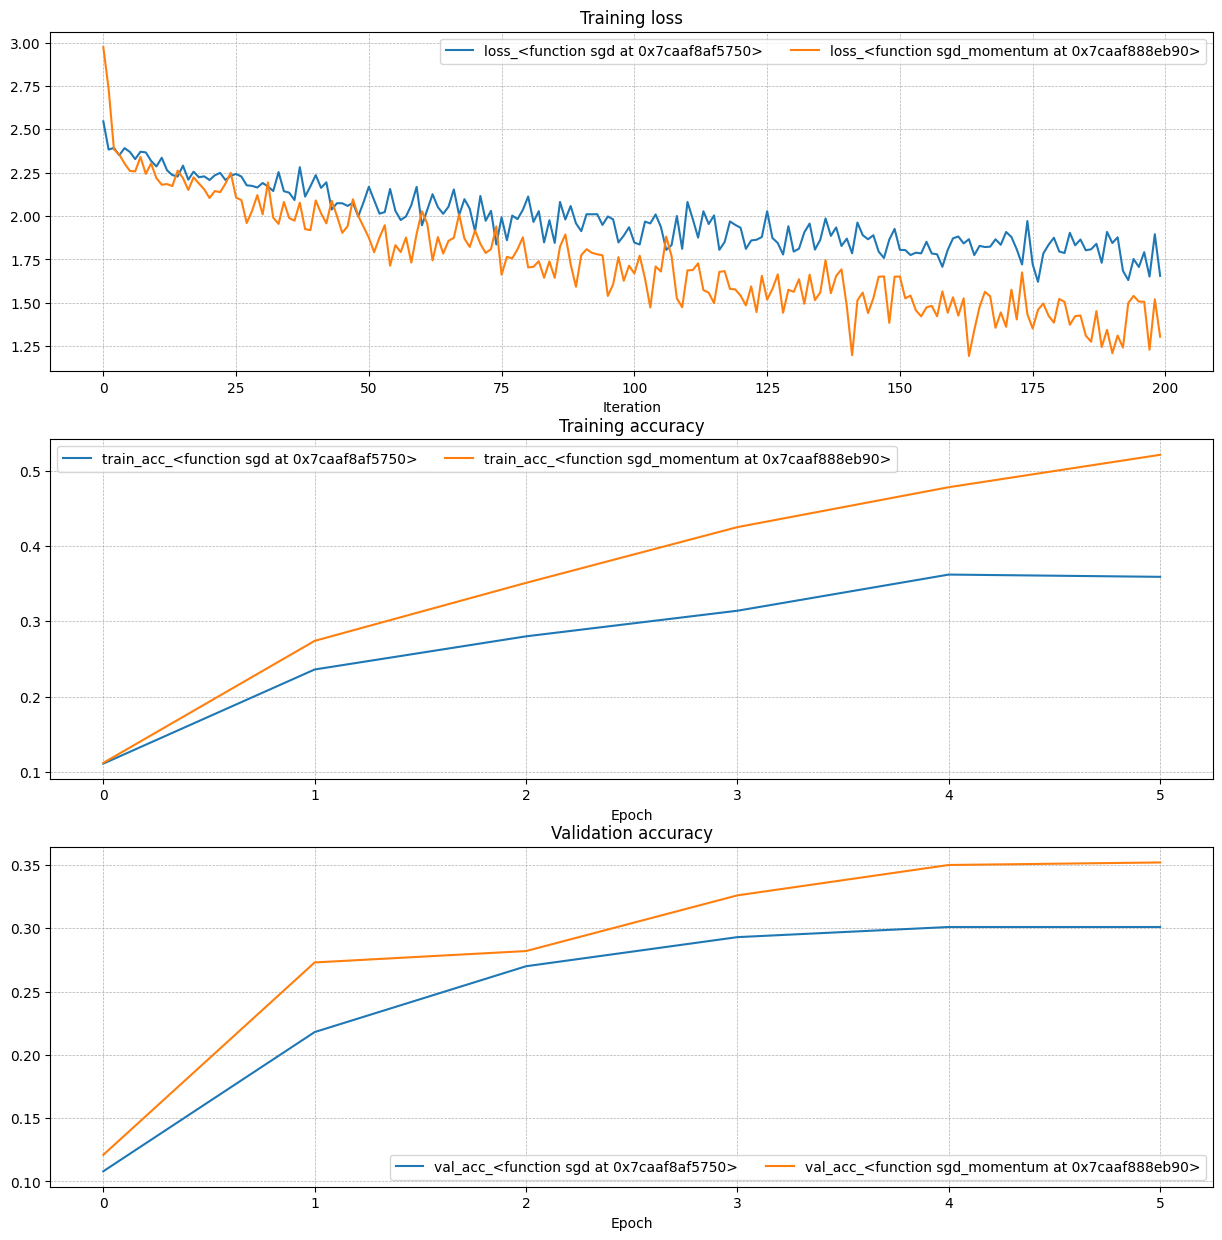

In [42]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in [sgd, sgd_momentum]:
    print('Running with', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )

    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': 5e-3},
        verbose=True,
    )
    solvers[update_rule] = solver
    solver.train()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"loss_{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"train_acc_{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"val_acc_{update_rule}")

for ax in axes:
    ax.legend(loc="best", ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## Congratulations! You are so much better than yesterday :)

# But not done yet!

# Q3: Adam (15 points)
Adam [1] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

Now, implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the simplified version mentioned in the lecture.
[This course notes](https://cs231n.github.io/neural-networks-3/) provide explaination of bias correction mechanism and helpful guidance to complete this exercise.

***Challenge: Why is bias correction needed?***

[1] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [48]:
def adam(w, dw, config=None):
    """
    Uses the Adam update rule, which incorporates moving averages of both the
    gradient and its square and a bias correction term.

    config format:
    - learning_rate: Scalar learning rate.
    - beta1: Decay rate for moving average of first moment of gradient.
    - beta2: Decay rate for moving average of second moment of gradient.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - m: Moving average of gradient.
    - v: Moving average of squared gradient.
    - t: Iteration number.
    """
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-3)
    config.setdefault("beta1", 0.9)
    config.setdefault("beta2", 0.999)
    config.setdefault("epsilon", 1e-8)
    config.setdefault("m", np.zeros_like(w))
    config.setdefault("v", np.zeros_like(w))
    config.setdefault("t", 0)

    next_w = None
    ###########################################################################
    # TODO: Implement the Adam update formula, storing the next value of w in #
    # the next_w variable. Don't forget to update the m, v, and t variables   #
    # stored in config.                                                       #
    #                                                                         #
    # NOTE: In order to match the reference output, please modify t _before_  #
    # using it in any calculations.                                           #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    learning_rate = config["learning_rate"]
    beta1 = config["beta1"]
    beta2 = config["beta2"]
    epsilon = config["epsilon"]
    m = config["m"]
    v = config["v"]
    t = config["t"]

    # Update t
    t += 1


    # Update biased first moment estimate
    m = beta1 * m + (1 - beta1) * dw

    # Update biased second raw moment estimate
    v = beta2 * v + (1 - beta2) * (dw ** 2)

    # Compute bias-corrected first moment estimate
    m_hat = m / (1 - beta1 ** t)

    # Compute bias-corrected second moment estimate
    v_hat = v / (1 - beta2 ** t)

    # Update weights
    next_w = w - learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

    config["m"] = m
    config["v"] = v
    config["t"] = t
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return next_w, config


### Public test

In [49]:
N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


# Q4: Dropout (30 points)

Dropout [1] is a technique for regularizing neural networks by randomly setting some output activations to zero during the forward pass. In this exercise, you will implement a dropout layer and modify your fully connected network to optionally use dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

## Dropout: Forward Pass (6 points)
Implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

In [50]:
def dropout_forward(x, dropout_param):
    """Forward pass for inverted dropout.

    Note that this is different from the vanilla version of dropout.
    Here, p is the probability of keeping a neuron output, as opposed to
    the probability of dropping a neuron output.
    See http://cs231n.github.io/neural-networks-2/#reg for more details.

    Inputs:
    - x: Input data, of any shape
    - dropout_param: A dictionary with the following keys:
      - p: Dropout parameter. We keep each neuron output with probability p.
      - mode: 'test' or 'train'. If the mode is train, then perform dropout;
        if the mode is test, then just return the input.
      - seed: Seed for the random number generator. Passing seed makes this
        function deterministic, which is needed for gradient checking but not
        in real networks.

    Outputs:
    - out: Array of the same shape as x.
    - cache: tuple (dropout_param, mask). In training mode, mask is the dropout
      mask that was used to multiply the input; in test mode, mask is None.
    """
    p, mode = dropout_param["p"], dropout_param["mode"]
    if "seed" in dropout_param:
        np.random.seed(dropout_param["seed"])

    mask = None
    out = None

    if mode == "train":
        #######################################################################
        # TODO: Implement training phase forward pass for inverted dropout.   #
        # Store the dropout mask in the mask variable.                        #
        #######################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        mask = (np.random.rand(*x.shape) < p) / p
        out = x * mask
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        #######################################################################
        #                           END OF YOUR CODE                          #
        #######################################################################
    elif mode == "test":
        #######################################################################
        # TODO: Implement the test phase forward pass for inverted dropout.   #
        #######################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        out = x  # During testing, we don't apply dropout, so output is same as input.

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        #######################################################################
        #                            END OF YOUR CODE                         #
        #######################################################################

    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache

### Public Test
Run the cell below to test your implementation.

In [51]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    print()

Running tests with p =  0.25
Mean of input:  10.000207878477502
Mean of train-time output:  10.014059116977283
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.749784
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  10.000207878477502
Mean of train-time output:  9.977917658761159
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.600796
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  10.000207878477502
Mean of train-time output:  9.987811912159426
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.30074
Fraction of test-time output set to zero:  0.0



## Dropout: Backward Pass (8 points)
Implement the backward pass for dropout.

In [52]:
def dropout_backward(dout, cache):
    """Backward pass for inverted dropout.

    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (dropout_param, mask) from dropout_forward.
    """
    dropout_param, mask = cache
    mode = dropout_param["mode"]

    dx = None
    if mode == "train":
        #######################################################################
        # TODO: Implement training phase backward pass for inverted dropout   #
        #######################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        dx = dout * mask  # The gradient of dropout layer is simply the upstream gradient multiplied by the dropout mask.

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        #######################################################################
        #                          END OF YOUR CODE                           #
        #######################################################################
    elif mode == "test":
        dx = dout
    return dx

In [53]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 1223}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less.
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.445604556245897e-11


## Fully Connected Networks with Dropout (16 points)

In the `FullyConnectedNet` class, modify your implementation to use dropout. Specifically, if the constructor of the network receives a value that is not 1 for the `dropout_keep_ratio` parameter, then the net should add a dropout layer immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

### **Note: Just do Dropout task, we will comeback to do BatchNorm task later**

In [ ]:
class FullyConnectedNet_v2(object):
    """Class for a multi-layer fully connected neural network.

    Network contains an arbitrary number of hidden layers, ReLU nonlinearities,
    and a softmax loss function. This will also implement dropout and batch/layer
    normalization as options. For a network with L layers, the architecture will be

    {linear - [batch/layer norm] - relu - [dropout]} x (L - 1) - linear - softmax

    where batch/layer normalization and dropout are optional and the {...} block is
    repeated L - 1 times.

    Learnable parameters are stored in the self.params dictionary and will be learned
    using the Solver class.
    """

    def __init__(
        self,
        hidden_dims,
        input_dim=3 * 32 * 32,
        num_classes=10,
        dropout_keep_ratio=1,
        normalization=None,
        reg=0.0,
        weight_scale=1e-2,
        dtype=np.float32,
        seed=None,
    ):
        """Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - dropout_keep_ratio: Scalar between 0 and 1 giving dropout strength.
            If dropout_keep_ratio=1 then the network should not use dropout at all.
        - normalization: What type of normalization the network should use. Valid values
            are "batchnorm", "layernorm", or None for no normalization (the default).
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
            initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
            this datatype. float32 is faster but less accurate, so you should use
            float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers.
            This will make the dropout layers deteriminstic so we can gradient check the model.
        """
        self.normalization = normalization
        self.use_dropout = dropout_keep_ratio != 1
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        szs = [input_dim] + hidden_dims + [num_classes]
        for i in range(self.num_layers):
            self.params[f"W{i+1}"] = np.random.normal(0., weight_scale, size=(szs[i], szs[i+1]))
            self.params[f"b{i+1}"] = np.zeros(szs[i+1])
            if self.normalization=="batchnorm" and i < len(hidden_dims):
                self.params[f"gamma{i+1}"] = np.ones(szs[i+1])
                self.params[f"beta{i+1}"] = np.zeros(szs[i+1])

        # When using dropout we need to pass a dropout_param dictionary to each
        # dropout layer so that the layer knows the dropout probability and the mode
        # (train / test). You can pass the same dropout_param to each dropout layer.
        self.dropout_param = {}
        if self.use_dropout:
            self.dropout_param = {"mode": "train", "p": dropout_keep_ratio}
            if seed is not None:
                self.dropout_param["seed"] = seed

        # With batch normalization we need to keep track of running means and
        # variances, so we need to pass a special bn_param object to each batch
        # normalization layer. You should pass self.bn_params[0] to the forward pass
        # of the first batch normalization layer, self.bn_params[1] to the forward
        # pass of the second batch normalization layer, etc.
        self.bn_params = []
        if self.normalization == "batchnorm":
            self.bn_params = [{"mode": "train"} for i in range(self.num_layers - 1)]

        # Cast all parameters to the correct datatype.
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)

    def loss(self, X, y=None):
        """Compute loss and gradient for the fully connected net.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
            scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
            names to gradients of the loss with respect to those parameters.
        """
        X = X.astype(self.dtype)
        mode = "test" if y is None else "train"

        # Set train/test mode for batchnorm params and dropout param since they
        # behave differently during training and testing.
        if self.use_dropout:
            self.dropout_param["mode"] = mode
        if self.normalization == "batchnorm":
            for bn_param in self.bn_params:
                bn_param["mode"] = mode
        scores = None

        ############################################################################
        # TODO: Implement the forward pass for the fully connected net, computing  #
        # the class scores for X and storing them in the scores variable.          #
        #                                                                          #
        # When using dropout, you'll need to pass self.dropout_param to each       #
        # dropout forward pass.                                                    #
        #                                                                          #
        # When using batch normalization, you'll need to pass self.bn_params[0] to #
        # the forward pass for the first batch normalization layer, pass           #
        # self.bn_params[1] to the forward pass for the second batch normalization #
        # layer, etc.                                                              #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        cache = {}

        out = X
        for i in range(self.num_layers - 1):
          # Select weights and biases
          W = self.params[f"W{i+1}"]
          b = self.params[f"b{i+1}"]

        # Perform linear transformation
        out, cache[f"linear{i+1}"] = linear_forward(out, W, b)

        # Apply batch/layer normalization if specified
        if self.normalization == "batchnorm":
            gamma = self.params[f"gamma{i+1}"]
            beta = self.params[f"beta{i+1}"]
            bn_param = self.bn_params[i]
            out, cache[f"batchnorm{i+1}"] = batchnorm_forward(out, gamma, beta, bn_param)
        elif self.normalization == "layernorm":
            gamma = self.params[f"gamma{i+1}"]
            beta = self.params[f"beta{i+1}"]
            ln_param = self.bn_params[i]
            out, cache[f"layernorm{i+1}"] = layernorm_forward(out, gamma, beta, ln_param)

        # Apply ReLU activation function
        out, cache[f"relu{i+1}"] = relu_forward(out)

        # Apply dropout if specified
        if self.use_dropout:
            out, cache[f"dropout{i+1}"] = dropout_forward(out, self.dropout_param)

        # Last layer: linear transformation
        W = self.params[f"W{self.num_layers}"]
        b = self.params[f"b{self.num_layers}"]
        scores, cache[f"linear{self.num_layers}"] = linear_forward(out, W, b)

        scores = X


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If test mode return early.
        if mode == "test":
            return scores


        loss, grads = 0.0, {}
        ############################################################################
        # TODO: Implement the backward pass for the fully-connected net. Store the #
        # loss in the loss variable and gradients in the grads dictionary. Compute #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # When using batch/layer normalization, you don't need to regularize the   #
        # scale and shift parameters.                                              #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        raise NotImplementedError()  # Remove or comment out this code while coding.

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

### Public test

In [ ]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout_keep_ratio in [1, 0.75, 0.5]:
    print('Running check with dropout = ', dropout_keep_ratio)
    model = FullyConnectedNet_v2(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        weight_scale=5e-2,
        dtype=np.float64,
        dropout_keep_ratio=dropout_keep_ratio,
        seed=123
    )

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    # Relative errors should be around e-6 or less.
    # Note that it's fine if for dropout_keep_ratio=1 you have W2 error be on the order of e-5.
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    print()

Running check with dropout =  1
Initial loss:  2.3004790897684924
W1 relative error: 1.03e-07
W2 relative error: 1.01e-05
W3 relative error: 4.44e-07
b1 relative error: 4.66e-09
b2 relative error: 2.09e-09
b3 relative error: 6.11e-11

Running check with dropout =  0.75
Initial loss:  2.302371489704412
W1 relative error: 1.90e-07
W2 relative error: 4.76e-06
W3 relative error: 2.60e-08
b1 relative error: 2.19e-09
b2 relative error: 1.82e-09
b3 relative error: 2.29e-10

Running check with dropout =  0.5
Initial loss:  2.30427592207859
W1 relative error: 3.11e-07
W2 relative error: 5.55e-08
W3 relative error: 6.47e-08
b1 relative error: 5.37e-09
b2 relative error: 1.91e-09
b3 relative error: 9.54e-11



## Regularization Experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a keep probability of 0.25. We will then visualize the training and validation accuracies of the two networks over time.

In [ ]:
# Train two identical nets, one with dropout and one without.
np.random.seed(231)
num_train = 500
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.25]
for dropout_keep_ratio in dropout_choices:
    model = FullyConnectedNet_v2(
        [500],
        dropout_keep_ratio=dropout_keep_ratio
    )
    print(dropout_keep_ratio)

    solver = Solver(
        model,
        small_data,
        num_epochs=25,
        batch_size=100,
        update_rule=adam,
        optim_config={'learning_rate': 5e-4,},
        verbose=True,
        print_every=100
    )
    solver.train()
    solvers[dropout_keep_ratio] = solver
    print()

1
(Iteration 1 / 125) loss: 7.856643
(Epoch 0 / 25) train acc: 0.260000; val_acc: 0.184000
(Epoch 1 / 25) train acc: 0.416000; val_acc: 0.258000
(Epoch 2 / 25) train acc: 0.482000; val_acc: 0.276000
(Epoch 3 / 25) train acc: 0.532000; val_acc: 0.277000
(Epoch 4 / 25) train acc: 0.600000; val_acc: 0.271000
(Epoch 5 / 25) train acc: 0.708000; val_acc: 0.299000
(Epoch 6 / 25) train acc: 0.722000; val_acc: 0.282000
(Epoch 7 / 25) train acc: 0.832000; val_acc: 0.255000
(Epoch 8 / 25) train acc: 0.880000; val_acc: 0.267000
(Epoch 9 / 25) train acc: 0.902000; val_acc: 0.278000
(Epoch 10 / 25) train acc: 0.898000; val_acc: 0.262000
(Epoch 11 / 25) train acc: 0.920000; val_acc: 0.267000
(Epoch 12 / 25) train acc: 0.964000; val_acc: 0.302000
(Epoch 13 / 25) train acc: 0.968000; val_acc: 0.314000
(Epoch 14 / 25) train acc: 0.974000; val_acc: 0.307000
(Epoch 15 / 25) train acc: 0.966000; val_acc: 0.313000
(Epoch 16 / 25) train acc: 0.988000; val_acc: 0.315000
(Epoch 17 / 25) train acc: 0.966000; v

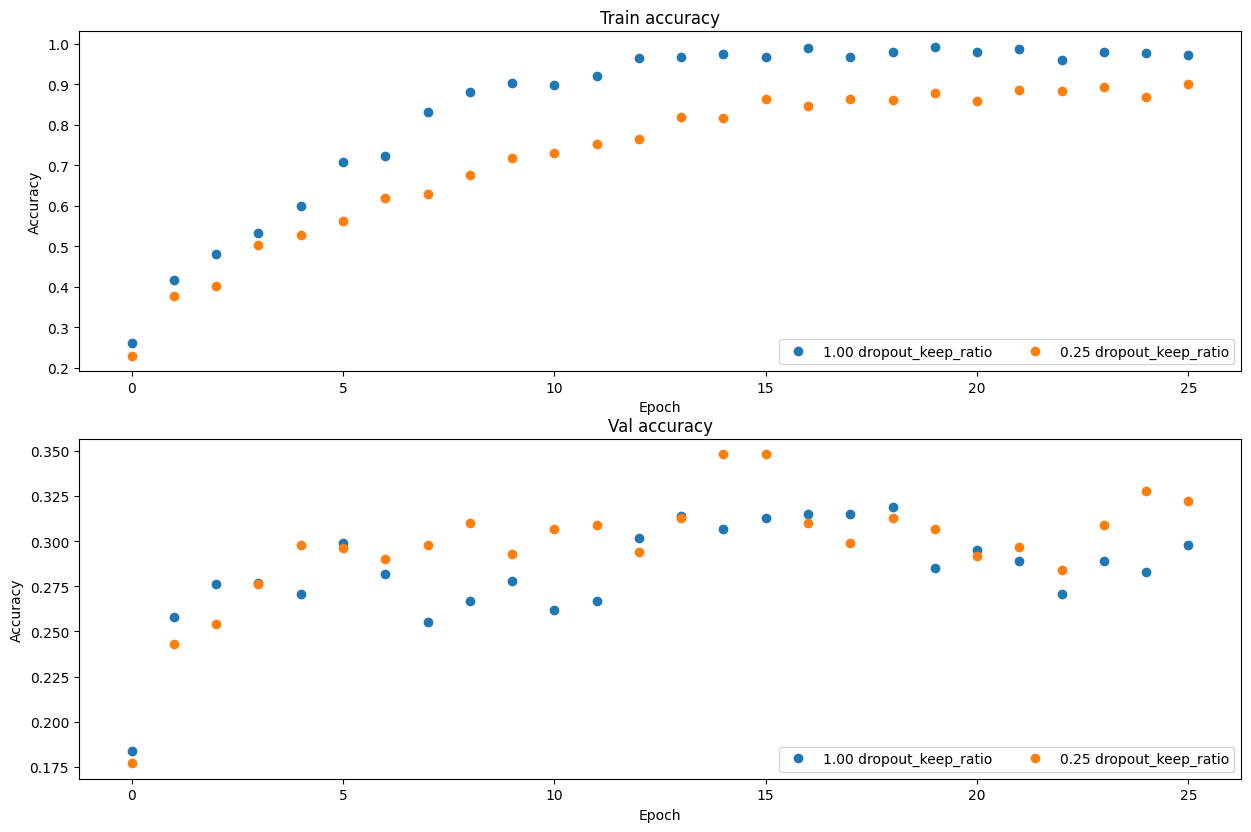

In [ ]:
# Plot train and validation accuracies of the two models.
train_accs = []
val_accs = []
for dropout_keep_ratio in dropout_choices:
    solver = solvers[dropout_keep_ratio]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout_keep_ratio in dropout_choices:
    plt.plot(
        solvers[dropout_keep_ratio].train_acc_history, 'o', label='%.2f dropout_keep_ratio' % dropout_keep_ratio)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
for dropout_keep_ratio in dropout_choices:
    plt.plot(
        solvers[dropout_keep_ratio].val_acc_history, 'o', label='%.2f dropout_keep_ratio' % dropout_keep_ratio)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Q5: Batch Normalization (20 points)

One way to make deep networks easier to train is to use more sophisticated optimization procedures such as SGD+momentum, RMSProp, or Adam. Another strategy is to change the architecture of the network to make it easier to train. One idea along these lines is batch normalization, proposed by [1] in 2015.

To understand the goal of batch normalization, it is important to first recognize that machine learning methods tend to perform better with input data consisting of uncorrelated features with zero mean and unit variance. When training a neural network, we can preprocess the data before feeding it to the network to explicitly decorrelate its features. This will ensure that the first layer of the network sees data that follows a nice distribution. However, even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance, since they are output from earlier layers in the network. Even worse, during the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated.

The authors of [1] hypothesize that the shifting distribution of features inside deep neural networks may make training deep networks more difficult. To overcome this problem, they propose to insert into the network layers that normalize batches. At training time, such a layer uses a minibatch of data to estimate the mean and standard deviation of each feature. These estimated means and standard deviations are then used to center and normalize the features of the minibatch. A running average of these means and standard deviations is kept during training, and at test time these running averages are used to center and normalize features.

It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are not zero-mean or unit variance. To this end, the batch normalization layer includes learnable shift and scale parameters for each feature dimension.

[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

## Batch Normalization: Forward Pass (8 points)
Implement the batch normalization forward pass in the function `batchnorm_forward`.

Referencing the paper linked to above in [1] may be helpful!

In [ ]:
def batchnorm_forward(x, gamma, beta, bn_param):
    """
    Forward pass for batch normalization.
    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the
    mean and variance of each feature, and these averages are used to normalize
    data at test-time.
    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:
    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var
    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7
    implementation of batch normalization also uses running averages.
    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features
    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)
    layernorm = bn_param.get('layernorm', 0)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':
        #######################################################################
        # TODO: Implement the training-time forward pass for batch norm.      #
        # Use minibatch statistics to compute the mean and variance, use      #
        # these statistics to normalize the incoming data, and scale and      #
        # shift the normalized data using gamma and beta.                     #
        #                                                                     #
        # You should store the output in the variable out. Any intermediates  #
        # that you need for the backward pass should be stored in the cache   #
        # variable.                                                           #
        #                                                                     #
        # You should also use your computed sample mean and variance together #
        # with the momentum variable to update the running mean and running   #
        # variance, storing your result in the running_mean and running_var   #
        # variables.                                                          #
        #                                                                     #
        # Note that though you should be keeping track of the running         #
        # variance, you should normalize the data based on the standard       #
        # deviation (square root of variance) instead!                        #
        # Referencing the original paper (https://arxiv.org/abs/1502.03167)   #
        # might prove to be helpful.                                          #
        #######################################################################

        raise NotImplementedError()  # Remove or comment out this code while coding.

        #######################################################################
        #                           END OF YOUR CODE                          #
        #######################################################################

        # save values for backward call
        shape = bn_param.get('shape', (N, D)) # reshape used in backprop
        cache = x, mu, var, std, gamma, x_hat, shape

    elif mode == 'test':
        #######################################################################
        # TODO: Implement the test-time forward pass for batch normalization. #
        # Use the running mean and variance to normalize the incoming data,   #
        # then scale and shift the normalized data using gamma and beta.      #
        # Store the result in the out variable.                               #
        #######################################################################

        raise NotImplementedError()  # Remove or comment out this code while coding.

        #######################################################################
        #                          END OF YOUR CODE                           #
        #######################################################################
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    return out, cache

### Public test
Once you have done so, run the following to test your implementation.

#### Training time

In [ ]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization

# Simulate the forward pass for a two-layer network.
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print_mean_std(a,axis=0)

gamma = np.ones((D3,))
beta = np.zeros((D3,))

# Means should be close to zero and stds close to one.
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])

# Now means should be close to beta and stds close to gamma.
print('After batch normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

Before batch normalization:
  means: [ -2.3814598  -13.18038246   1.91780462]
  stds:  [27.18502186 34.21455511 37.68611762]

After batch normalization (gamma=1, beta=0)
  means: [ 3.55271368e-17  1.71529457e-16 -2.76167977e-17]
  stds:  [0.99999999 1.         1.        ]

After batch normalization (gamma= [1. 2. 3.] , beta= [11. 12. 13.] )
  means: [11. 12. 13.]
  stds:  [0.99999999 1.99999999 2.99999999]



#### Testing time

In [ ]:
# Check the testing-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)

for t in range(50):
  X = np.random.randn(N, D1)
  a = np.maximum(0, X.dot(W1)).dot(W2)
  batchnorm_forward(a, gamma, beta, bn_param)

bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print_mean_std(a_norm,axis=0)

After batch normalization (test-time):
  means: [-0.03927354 -0.04349152 -0.10452688]
  stds:  [1.01531428 1.01238373 0.97819988]



## Fully Connected Networks with Batch Normalization (12 points)
Now that you have a working implementation for batch normalization. Go back to your `FullyConnectedNet` and modify your implementation to add batch normalization.

Concretely, when the `normalization` flag is set to `"batchnorm"` in the constructor, you should insert a batch normalization layer before each ReLU nonlinearity. The outputs from the last layer of the network should not be normalized. Once you are done, run the following to gradient-check your implementation.

### Note: Comeback to [FullyConnectedNet_v2](#scrollTo=3pdmv-Ju_KxF&line=6&uniqifier=1) function in dropout task to add new BatchNorm

**Hint:** You might find it useful to use `linear_norm_relu_forward` and `linear_norm_relu_backward` functions in the Utils section.

In [ ]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

# You should expect losses between 1e-4~1e-10 for W,
# losses between 1e-08~1e-10 for b,
# and losses between 1e-08~1e-09 for beta and gammas.
for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet_v2([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            normalization='batchnorm')

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  if reg == 0: print()

Running check with reg =  0
Initial loss:  2.2611955101340957
W1 relative error: 1.10e-04
W2 relative error: 2.85e-06
W3 relative error: 4.13e-10
b1 relative error: 2.22e-08
b2 relative error: 5.55e-09
b3 relative error: 1.02e-10
beta1 relative error: 7.33e-09
beta2 relative error: 1.89e-09
gamma1 relative error: 6.96e-09
gamma2 relative error: 3.35e-09

Running check with reg =  3.14
Initial loss:  6.996533220108303
W1 relative error: 1.98e-06
W2 relative error: 2.28e-06
W3 relative error: 2.79e-08
b1 relative error: 5.55e-09
b2 relative error: 2.22e-08
b3 relative error: 2.10e-10
beta1 relative error: 6.65e-09
beta2 relative error: 3.48e-09
gamma1 relative error: 5.94e-09
gamma2 relative error: 5.78e-09


## Batch Normalization for Deep Networks
Run the following to train a six-layer network on a subset of 1000 training examples both with and without batch normalization.

In [ ]:
np.random.seed(231)

# Try training a very deep net with batchnorm.
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet_v2(hidden_dims, weight_scale=weight_scale, normalization='batchnorm')
model = FullyConnectedNet_v2(hidden_dims, weight_scale=weight_scale, normalization=None)

print('Solver with batch norm:')
bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule=adam,
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True,print_every=20)
bn_solver.train()

print('\nSolver without batch norm:')
solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule=adam,
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

Solver with batch norm:
(Iteration 1 / 200) loss: 2.340974
(Epoch 0 / 10) train acc: 0.107000; val_acc: 0.115000
(Epoch 1 / 10) train acc: 0.314000; val_acc: 0.266000
(Iteration 21 / 200) loss: 2.039365
(Epoch 2 / 10) train acc: 0.385000; val_acc: 0.279000
(Iteration 41 / 200) loss: 2.041103
(Epoch 3 / 10) train acc: 0.494000; val_acc: 0.308000
(Iteration 61 / 200) loss: 1.753903
(Epoch 4 / 10) train acc: 0.531000; val_acc: 0.307000
(Iteration 81 / 200) loss: 1.246584
(Epoch 5 / 10) train acc: 0.574000; val_acc: 0.313000
(Iteration 101 / 200) loss: 1.320590
(Epoch 6 / 10) train acc: 0.634000; val_acc: 0.338000
(Iteration 121 / 200) loss: 1.157329
(Epoch 7 / 10) train acc: 0.683000; val_acc: 0.323000
(Iteration 141 / 200) loss: 1.135146
(Epoch 8 / 10) train acc: 0.769000; val_acc: 0.327000
(Iteration 161 / 200) loss: 0.694051
(Epoch 9 / 10) train acc: 0.796000; val_acc: 0.334000
(Iteration 181 / 200) loss: 0.949174
(Epoch 10 / 10) train acc: 0.790000; val_acc: 0.329000

Solver without b

Run the following to visualize the results from two networks trained above. You should find that using batch normalization helps the network to converge much faster.

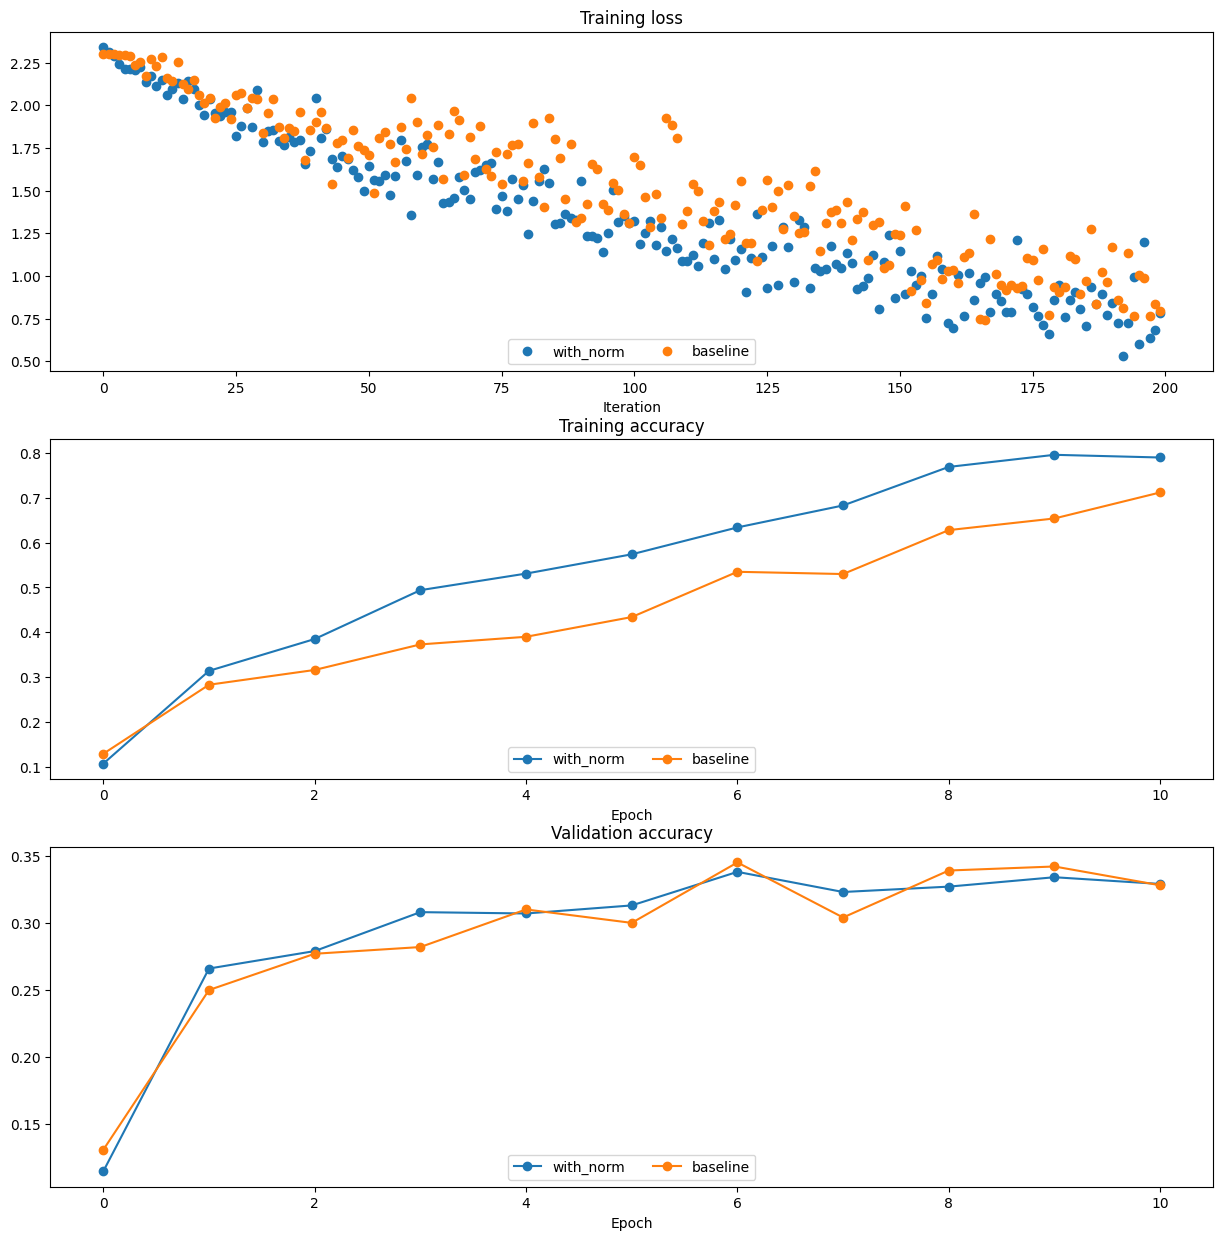

In [ ]:
def plot_training_history(title, label, baseline, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
    bl_plot = plot_fn(baseline)
    num_bn = len(bn_plots)
    for i in range(num_bn):
        label='with_norm'
        if labels is not None:
            label += str(labels[i])
        plt.plot(bn_plots[i], bn_marker, label=label)
    label='baseline'
    if labels is not None:
        label += str(labels[0])
    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_bn+1)


plt.subplot(3, 1, 1)
plot_training_history('Training loss','Iteration', solver, [bn_solver], \
                      lambda x: x.loss_history, bl_marker='o', bn_marker='o')
plt.subplot(3, 1, 2)
plot_training_history('Training accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.train_acc_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history('Validation accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.val_acc_history, bl_marker='-o', bn_marker='-o')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Batch Normalization and Initialization
We will now run a small experiment to study the interaction of batch normalization and weight initialization.

The first cell will train eight-layer networks both with and without batch normalization using different scales for weight initialization. The second layer will plot training accuracy, validation set accuracy, and training loss as a function of the weight initialization scale.

In [ ]:
np.random.seed(231)

# Try training a very deep net with batchnorm.
hidden_dims = [50, 50, 50, 50, 50, 50, 50]
num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers_ws = {}
solvers_ws = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
    print('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
    bn_model = FullyConnectedNet_v2(hidden_dims, weight_scale=weight_scale, normalization='batchnorm')
    model = FullyConnectedNet_v2(hidden_dims, weight_scale=weight_scale, normalization=None)

    bn_solver = Solver(bn_model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule=adam,
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
    bn_solver.train()
    bn_solvers_ws[weight_scale] = bn_solver

    solver = Solver(model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule=adam,
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
    solver.train()
    solvers_ws[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20
Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


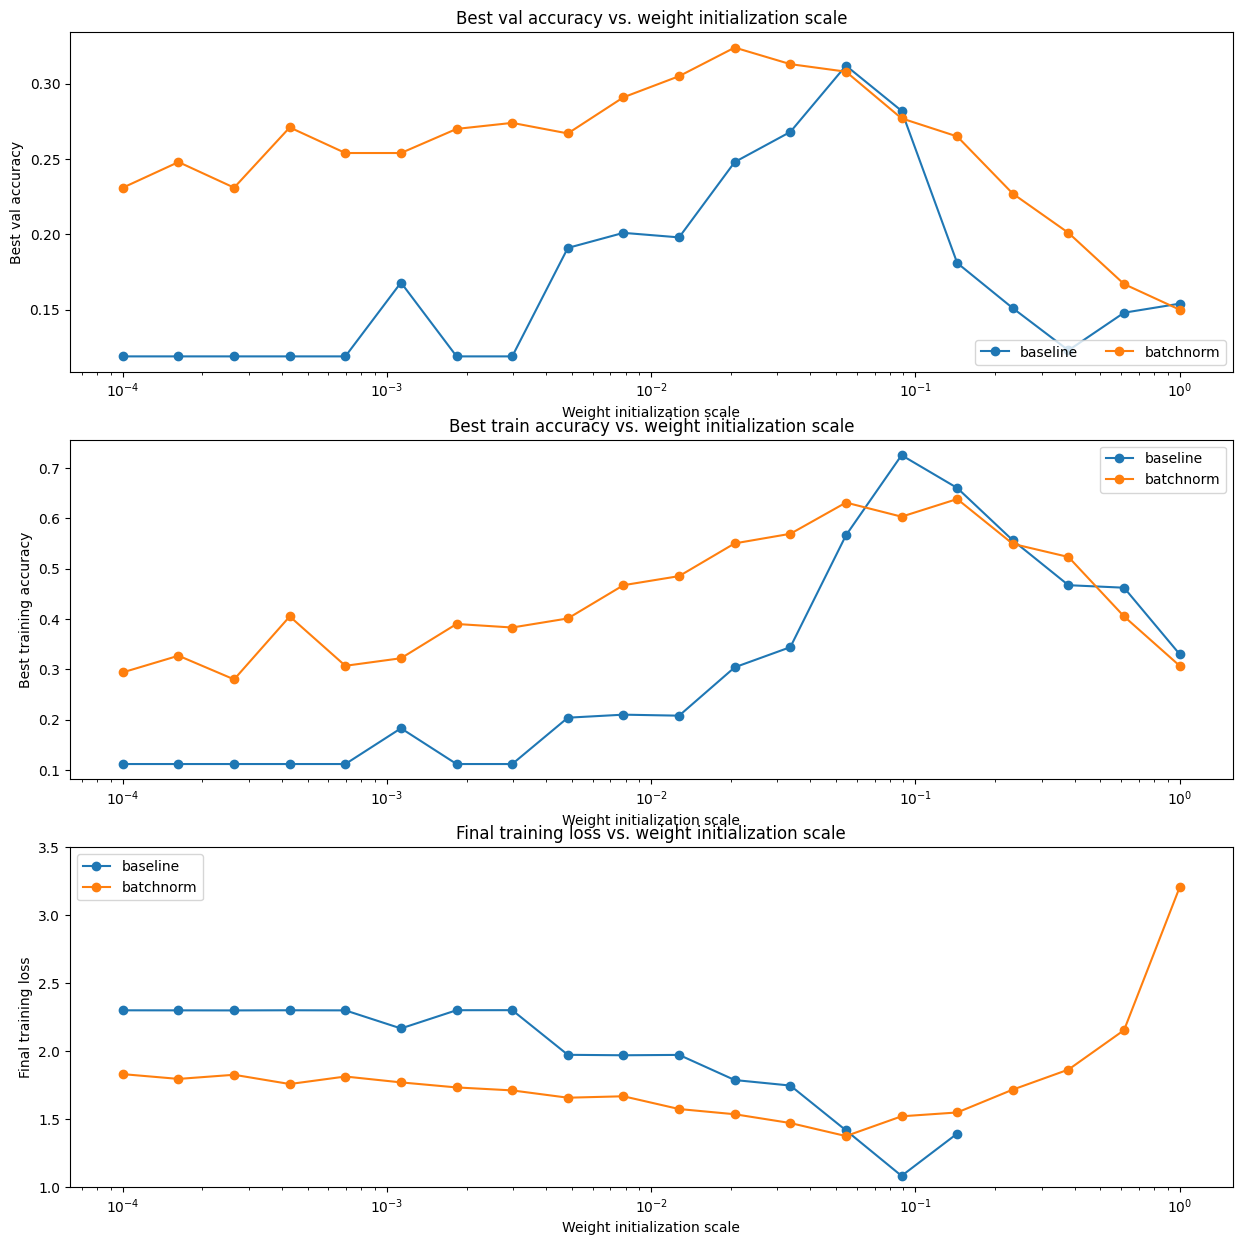

In [ ]:
# Plot results of weight scale experiment.
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
  best_train_accs.append(max(solvers_ws[ws].train_acc_history))
  bn_best_train_accs.append(max(bn_solvers_ws[ws].train_acc_history))

  best_val_accs.append(max(solvers_ws[ws].val_acc_history))
  bn_best_val_accs.append(max(bn_solvers_ws[ws].val_acc_history))

  final_train_loss.append(np.mean(solvers_ws[ws].loss_history[-100:]))
  bn_final_train_loss.append(np.mean(bn_solvers_ws[ws].loss_history[-100:]))

plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs. weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs. weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs. weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()
plt.gca().set_ylim(1.0, 3.5)

plt.gcf().set_size_inches(15, 15)
plt.show()

***Challenge:***
Describe the results of this experiment. How does the weight initialization scale affect models with/without batch normalization differently, and why?



## Batch Normalization and Batch Size
We will now run a small experiment to study the interaction of batch normalization and batch size.

The first cell will train 6-layer networks both with and without batch normalization using different batch sizes. The second layer will plot training accuracy and validation set accuracy over time.

In [ ]:
def run_batchsize_experiments(normalization_mode):
    np.random.seed(231)

    # Try training a very deep net with batchnorm.
    hidden_dims = [100, 100, 100, 100, 100]
    num_train = 1000
    small_data = {
      'X_train': data['X_train'][:num_train],
      'y_train': data['y_train'][:num_train],
      'X_val': data['X_val'],
      'y_val': data['y_val'],
    }
    n_epochs=10
    weight_scale = 2e-2
    batch_sizes = [5,10,50]
    lr = 10**(-3.5)
    solver_bsize = batch_sizes[0]

    print('No normalization: batch size = ',solver_bsize)
    model = FullyConnectedNet_v2(hidden_dims, weight_scale=weight_scale, normalization=None)
    solver = Solver(model, small_data,
                    num_epochs=n_epochs, batch_size=solver_bsize,
                    update_rule=adam,
                    optim_config={
                      'learning_rate': lr,
                    },
                    verbose=False)
    solver.train()

    bn_solvers = []
    for i in range(len(batch_sizes)):
        b_size=batch_sizes[i]
        print('Normalization: batch size = ',b_size)
        bn_model = FullyConnectedNet_v2(hidden_dims, weight_scale=weight_scale, normalization=normalization_mode)
        bn_solver = Solver(bn_model, small_data,
                        num_epochs=n_epochs, batch_size=b_size,
                        update_rule=adam,
                        optim_config={
                          'learning_rate': lr,
                        },
                        verbose=False)
        bn_solver.train()
        bn_solvers.append(bn_solver)

    return bn_solvers, solver, batch_sizes

batch_sizes = [5,10,50]
bn_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('batchnorm')

No normalization: batch size =  5
Normalization: batch size =  5
Normalization: batch size =  10
Normalization: batch size =  50


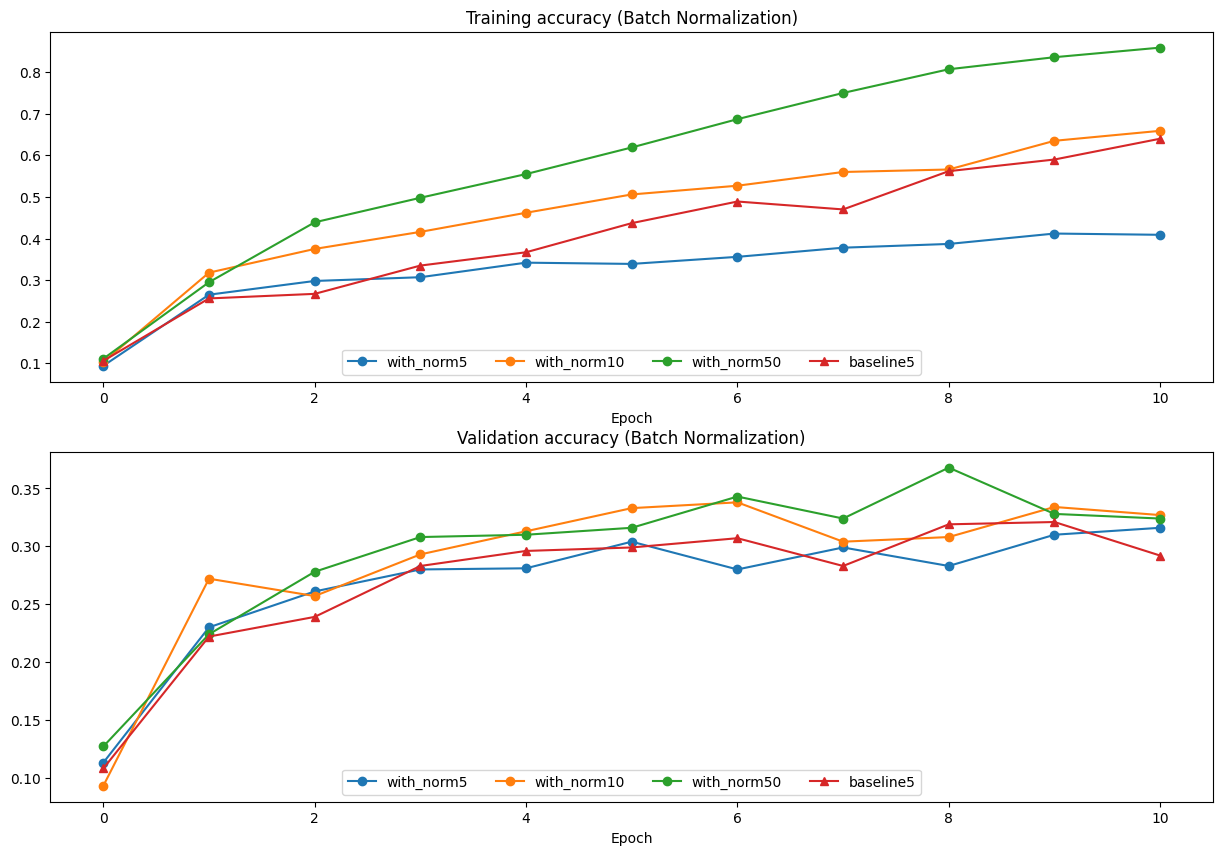

In [ ]:
plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

***Challenge:***
Describe the results of this experiment. What does this imply about the relationship between batch normalization and batch size? Why is this relationship observed?

# Keep up the great work in your coding endeavors! You're doing fantastic!
# So Proud of You <3

In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	cifar-10-batches-py/
	utils/__pycache__/

nothing added to commit but untracked files present (use "git add" to track)


In [ ]:
!git diff cifar-10-batches-py
